In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from icecream import ic


In [2]:
x = 0

# Functions required

In [31]:
def get_margins(mu, N, M, t, T, delta):
    delta = 0.1
    val1 = N*(M+1)/2/delta
    val2 = t**3
    val = val1*val2
    # print(val)
    log_term = math.log(val)
    sqrt_term = log_term/4/T
    alpha = math.sqrt(sqrt_term)
    # print("mu: ", mu, "t: ", t, "T: ", T, "alpha: ", alpha)
    LCB = mu - alpha
    UCB = mu + alpha
    return LCB, UCB

In [4]:
def get_feasible_set(mu_th, UCB_attr):
    ## mu_attr will be an array with the current means of all attributes of the specific arm
    ## same for UCB and LCB things
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    n = len(UCB_attr)
    m = len(UCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        UCB_min = min(UCB_attr[i])
        if (UCB_min >= mu_th):
            feasible_set.append(i)

    return feasible_set

In [5]:
def get_perfect_feasible_set(mu_th, LCB_attr):
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    # n = len(LCB_attr)
    n = len(LCB_attr)
    for i in range (n):
        ## for each arm
        LCB_min  = min(LCB_attr[i])
        if (LCB_min >= mu_th):
            feasible_set.append(i)

    return feasible_set

In [6]:
def best_arm(mu, feasible_set):
    ## for arms in feasible set, we need to find the arm with maximum mean
    best = feasible_set[0]
    for arm in feasible_set:
        # print(arm)
        if(mu[arm] >= mu[best]):
            best = arm
    return best

In [7]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [8]:
def potentially_competitor_arm(UCB, feasible_set, potentially_best_arm):
    if (potentially_best_arm != feasible_set[0]):
        best = feasible_set[0]
    else:
        best = feasible_set[1]
    for arm in feasible_set:
        if (arm != potentially_best_arm):
            if((UCB[arm] > UCB[best])):
                best = arm
    # print("pot: ", potentially_best_arm, "ct: ", best)
    return best

In [9]:
def get_suboptimal_arm(mu_i_star, mu_i, arms_set):
    suboptimal = []
    for arms in arms_set:
        if (mu_i[arms] < mu_i_star):
            suboptimal.append(arms)

    return suboptimal

In [10]:
def difference(li1, li2):
    s = set(li2)
    temp3 = [x for x in li1 if x not in s]
    return temp3

In [11]:
def get_margins_ae(mu, t, delta, N):
    c = (math.pi**2)/6
    val1 = 2*N*c*t*t/delta
    # print(t)
    alpha = math.sqrt(2*math.log(val1)/t)
    LCB = mu - alpha
    UCB = mu + alpha
    return LCB, UCB

In [12]:
# def best_arm_ae(mu, arm_set):
#     ## for arms in feasible set, we need to find the arm with maximum mean
#     best = arm_set[0]
#     for i in range (len(arm_set)):
#         arm
#     for arm in feasible_set:
#         # print(arm)
#         if(mu[arm] >= mu[best]):
#             best = arm
#     return best

In [13]:
def get_perfect_feasible_attr_set(mu_th, LCB_attr):
    perfect_feasible = []
    for i in range (len(LCB_attr)):
        for j in range (len(LCB_attr[0])):
            if LCB_attr[i][j] >= mu_th:
                perfect_feasible.append([i, j])

    return perfect_feasible

In [14]:
def get_possibly_feasible_attr_set(mu_th, LCB_attr, UCB_attr):
    ans = []
    # N, M = len(LCB_attr), len(UCB_attr)
    # print(N, M)
    for i in range(len(LCB_attr)):
        for j in range (len(UCB_attr[0])):
            if LCB_attr[i][j] < mu_th and UCB_attr[i][j] >= mu_th:
                ans.append([i, j])
    return ans

# Oracle

In [62]:
class Oracle:
    def __init__(self, M, N, mu_th) -> None:
        self.M = M
        self.N = N
        arms = 5
        attributes = 2
        self.mu_ij = [[0 for i in range (attributes)] for j in range (arms)]
        self.ab_array = [[[0, 0] for i in range (attributes)] for j in range (arms)]
        self.mu_i = [0 for i in range (arms)]

        self.mu_th = mu_th
        
        ## fixing alpha at 1

        self.ab_array[0] = np.array([[1, 0.67], [1, 0.43]])               #0.5
        self.ab_array[1] = np.array([[1, (1/x) - 1], [1, 0.11]])       #0.2
        self.ab_array[2] = np.array([[1, 2.33], [1, 0.82]])               #0.3
        self.ab_array[3] = np.array([[1, 0.82], [1, 0.82]])                  #0.4
        self.ab_array[4] = np.array([[1, 4], [1, 1.5]])                #0.3

        for i in range (arms):
            for j in range (attributes):
                alpha = self.ab_array[i][j][0]
                beta = self.ab_array[i][j][1]
                self.mu_ij[i][j] = alpha / (alpha + beta)


        for i in range (len(self.mu_i)):
            self.mu_i[i] = sum(self.mu_ij[i])/attributes

    def play(self, arm, attr):
        alpha, beta = self.ab_array[arm][attr]
        reward = np.random.beta(alpha, beta, 1)[0]
        return reward
    
    def hardness(self):
        self.i_star = 0                 ## best arm in the feasible set
        self.i_star_star = 1            ## best arm in suboptimal set

        self.delta_i = [0 for i in range (self.N)]
        self.delta_ij = [[0 for i in range (self.M)] for j in range (self.N)]
        self.delta_i_attr = [0 for i in range (self.N)]

         ### assume that always i_star is 0 ###
        
        all_arms = list(range(0, self.N))

        self.perfect_feasible = get_perfect_feasible_set(self.mu_th, self.mu_ij)
        self.i_star = best_arm(self.mu_i, self.perfect_feasible)

        self.suboptimal = get_suboptimal_arm(self.mu_i[self.i_star], self.mu_i, all_arms)
        self.i_star_star = best_arm(self.mu_i, self.suboptimal)
        
        self.risky = difference(all_arms, self.suboptimal)
        self.infeasible = difference(all_arms, self.perfect_feasible) 

        for i in range (self.N):
            if (i != self.i_star):
                self.delta_i[i] = self.mu_i[self.i_star] - self.mu_i[i]
                self.delta_i_attr[i] = abs(min(self.mu_ij[i]) - self.mu_th)

        self.delta_i[self.i_star] = self.delta_i[self.i_star_star]
        self.delta_i_attr[self.i_star] = abs(min(self.mu_ij[self.i_star]) - self.mu_th)

        return self.delta_i[self.i_star], self.delta_i_attr
    
    def H_index(self):
        self.i_star = 0                 ## best arm in the feasible set
        self.i_star_star = 1            ## best arm in suboptimal set

        self.delta_i = [0 for i in range (self.N)]
        self.delta_ij = [[0 for i in range (self.M)] for j in range (self.N)]
        self.delta_i_attr = [0 for i in range (self.N)]

         ### assume that always i_star is 0 ###
        
        all_arms = list(range(0, self.N))

        self.perfect_feasible = get_perfect_feasible_set(self.mu_th, self.mu_ij)
        self.i_star = best_arm(self.mu_i, self.perfect_feasible)

        self.suboptimal = get_suboptimal_arm(self.mu_i[self.i_star], self.mu_i, all_arms)
        self.i_star_star = best_arm(self.mu_i, self.suboptimal)
        
        self.risky = difference(all_arms, self.suboptimal)
        self.infeasible = difference(all_arms, self.perfect_feasible) 

        for i in range (self.N):
            if (i != self.i_star):
                self.delta_i[i] = self.mu_i[self.i_star] - self.mu_i[i]
                self.delta_i_attr[i] = abs(min(self.mu_ij[i]) - self.mu_th)

        self.delta_i[self.i_star] = self.delta_i[self.i_star_star]
        self.delta_i_attr[self.i_star] = abs(min(self.mu_ij[self.i_star]) - self.mu_th)
        # print(self.delta_i_attr)

        self.set1 = intersection(self.perfect_feasible, self.suboptimal)
        self.set2 = intersection(self.infeasible, self.risky)
        self.set3 = intersection(self.infeasible, self.suboptimal)

        h0_den = (min(self.delta_i[self.i_star]/2, self.delta_i_attr[self.i_star]))**2
        h0 = 1/h0_den

        h1 = 0
        for i in self.set1:
            h1 += 4/(self.delta_i[i])**2

        h2 = 0
        for i in self.set2:
            h2 += 1/(self.delta_i_attr[i])**2

        h3 = 0
        for i in self.set3:
            h3 += 1/(max(self.delta_i[i]/2, self.delta_i_attr[i]))**2
            # h3 += 5*np.exp((1/(max(self.delta_i[i]/2, 2*self.delta_i_attr[i]))**2)/192)

        h_index = h0 + h1 + h2 + h3
        # print(self.delta_i_attr[1])
        # print(h0, h1, h2, h3)
        # print(self.set2)

        return h_index

        

# Main Function

## Feasibility

In [16]:
def game(M, N, mu_th, delta):
    T_t_attr = [[0 for i in range (M)] for j in range (N)]
    T_t = [0 for i in range (N)]
    t = 1
    theGame = Oracle(M, N, mu_th)
    final_feasible_set = []

    h_idx, h_idx_old = 0, 0
    # h_idx_old = theGame.H_index_old()
    # h_idx = theGame.H_index()

    mu_hat_i = [0 for i in range (N)]
    mu_hat_ij = [[0 for i in range (M)] for j in range (N)]

    LCB = [0 for i in range (N)]
    UCB = [0 for i in range (N)]
    alpha = [0 for i in range(N)]

    LCB_attr = [[0 for i in range (M)] for j in range (N)]
    UCB_attr = [[0 for i in range (M)] for j in range (N)]

    T_unif = 20

    delta_i, delta_i_attr = theGame.hardness()

    for j in range (T_unif):
        ## 20 times uniform exploration
        for i in range (N):
            for k in range (M):
                reward_arm = theGame.play(i, k)
                mu_hat_ij[i][k] = (mu_hat_ij[i][k] * T_t_attr[i][k] + reward_arm)/(T_t_attr[i][k] + 1)
                T_t_attr[i][k] += 1
            mu_hat_i[i] = sum(mu_hat_ij[i])/M
            T_t[i] = sum(T_t_attr[i])

    all_arms = list(range(0, N))
    feasible = list(range(0, N))
    t += N*T_unif*M

    ### further pulls

    while(True):
        ## arm wise margins
        for i in range (N):
            LCB[i], UCB[i] = get_margins(mu_hat_i[i], N, M, t, T_t[i], delta)
            # LCB[i], UCB[i] = get_margins_ae(mu_hat_i[i], T_t[i], delta, N)
            alpha[i] = mu_hat_i[i] - LCB[i]

        ## attribute wise margins
        for i in range (N):
            for j in range (M):
                LCB_attr[i][j], UCB_attr[i][j] = get_margins(mu_hat_ij[i][j], N, M, t, T_t_attr[i][j], delta)
                # LCB_attr[i][j], UCB_attr[i][j] = get_margins_ae(mu_hat_ij[i][j], T_t[i], delta, N)

        # print("t: ", t, "T: ", T_t, "alpha: ", alpha, "mu: ", mu_hat_i)
        
        perfect_feasible = get_perfect_feasible_set(mu_th, LCB_attr)
        feasible = get_feasible_set(mu_th, UCB_attr)
        possibly_feasible = difference(feasible, perfect_feasible)

        perfect_feasible_attr = get_perfect_feasible_attr_set(mu_th, LCB_attr)                  ## this is the surely feasible set
        possibly_feasible_attr = get_possibly_feasible_attr_set(mu_th, LCB_attr, UCB_attr)               ## this is the dell f set

        # if(len(perfect_feasible) != 0):
        #     i_star_t = best_arm(mu_hat_i, perfect_feasible)
        # else:
        #     i_star_t = mu_hat_i.index(max(mu_hat_i))

        # if (len(feasible) != 0):
        #     i_t = best_arm(mu_hat_i, feasible)

        ## potential set is the set of arms which have more UCB than the  current best arm mean, irrespective of feasibility
        # if (len(perfect_feasible) == 0):
        #     potential = all_arms
        # else:
        #     potential = get_potential_set(i_star_t, LCB[i_star_t], UCB)
        
        # pot_intersect_feas = intersection(potential, feasible)

        # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "Potential: ", potential, "mu_hat for all", mu_hat_i, "UCB of all: ", UCB, "LCB for all: ", LCB)
        # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "mu_hat for all", mu_hat_i, "alpha: ", alpha)

        #  "i_t: ", i_t, "i_star: ", i_star_t,

        ## Stopping criteria
        if (len(possibly_feasible_attr) == 0):
            return perfect_feasible, t, delta_i, delta_i_attr
            # if(len(perfect_feasible) == 0):
            #     f_hat = 0
            #     i_out = N
            # else:
            #     f_hat = 1
            #     i_out = i_t
            # return i_out, f_hat, t, h_idx_old, h_idx
        
        for i, j in possibly_feasible_attr:
            reward_arm = theGame.play(i, j)
            t += 1
            mu_hat_ij[i][j] = (mu_hat_ij[i][j] * T_t_attr[i][j] + reward_arm)/(T_t_attr[i][j] + 1)
            T_t_attr[i][j] += 1
            T_t[i] += 1

        
        # if (len(possibly_feasible_attr) == 1):
        #     i_t = best_arm(mu_hat_i, possibly_feasible_attr)
        #     arm_next1 = i_t
        #     arm_next2 = i_t
        # else:
        #     i_t = best_arm(mu_hat_i, possibly_feasible)
        #     c_t = potentially_competitor_arm(UCB, possibly_feasible, i_t)
        #     arm_next1 = i_t
        #     arm_next2 = c_t

        # ## play the 2 arms found above
        # reward_arm1 = theGame.play(arm_next1)
        # reward_arm2 = theGame.play(arm_next2)
        # t += 2

        # for j in range (M):
        #     mu_hat_ij[arm_next1][j] = (mu_hat_ij[arm_next1][j] * T_t[arm_next1] + reward_arm1[j])/(T_t[arm_next1] + 1)
        #     mu_hat_ij[arm_next2][j] = (mu_hat_ij[arm_next2][j] * T_t[arm_next2] + reward_arm2[j])/(T_t[arm_next2] + 1)
        # mu_hat_i[arm_next1] = sum(mu_hat_ij[arm_next1])/M
        # mu_hat_i[arm_next2] = sum(mu_hat_ij[arm_next2])/M
        # T_t[arm_next1] += 1
        # T_t[arm_next2] += 1


## Best arm

In [17]:
def best_feasible_arm(M, N, arms, delta, mu_th):
    t = 1
    ### if only one feasible arm ###
    if (len(arms) == 1):
        return arms[0], t
    ################################

    # N = len(arms)
    T_t = [0 for i in range (N)]
    T_t_attr = [[0 for i in range (M)] for j in range (N)]
    t = 1
    theGame = Oracle(M, N, mu_th)

    h_idx, h_idx_old = 0, 0
    # h_idx_old = theGame.H_index_old()
    # h_idx = theGame.H_index()

    mu_hat_i = [0 for i in range (N)]
    mu_hat_ij = [[0 for i in range (M)] for j in range (N)]

    LCB = [0 for i in range (N)]
    UCB = [0 for i in range (N)]
    # alpha = [0 for i in range(N)]

    LCB_attr = [[0 for i in range (M)] for j in range (N)]
    UCB_attr = [[0 for i in range (M)] for j in range (N)]

    T_unif = 20

    for j in range (T_unif):
        ## 20 times uniform exploration
        for i in range (len(arms)):
            arm = arms[i]
            for k in range(M):
                reward_arm = theGame.play(arm, k)
                mu_hat_ij[arm][k] = (mu_hat_ij[arm][k] * T_t_attr[arm][k] + reward_arm)/(T_t_attr[arm][k] + 1)
                T_t_attr[arm][k] += 1
            mu_hat_i[arm] = sum(mu_hat_ij[arm])/M
            T_t[arm] += 1

    all_arms = arms
    # feasible = list(range(0, N))
    t += N*T_unif

    ############### Uniform exploration done ########################
    while(True):
        for i in range (len(arms)):
            arm = arms[i]
            LCB[arm], UCB[arm] = get_margins_ae(mu_hat_i[arm], T_t[arm], delta, N)

        # print(arms)
        i_star_t = best_arm(mu_hat_i, arms)

        E = []
        for i in range (len(arms)):
            arm = arms[i]
            if UCB[arm] < LCB[i_star_t]:
                E.append(arm)
        # print(E)
        arms = difference(arms, E)
        # print(arms)
        # ic(arms, E)
        # ic(LCB, UCB, i_star_t)
        if len(arms) == 1:
            return arms[0], t

        for i in range (len(arms)):
            arm = arms[i]
            for k in range(M):
                reward_arm = theGame.play(arm, k)
                mu_hat_ij[arm][k] = (mu_hat_ij[arm][k] * T_t_attr[arm][k] + reward_arm)/(T_t_attr[arm][k] + 1)
                T_t_attr[arm][k]
            mu_hat_i[arm] = sum(mu_hat_ij[arm])/M
            T_t[arm] += 1
            t += M

# Tests

## Single Instance

In [45]:
# self.mu_ij[0] = np.array([0.9, 0.1])        #0.5
#         self.mu_ij[1] = np.array([0.9, 0.5])        #0.7
#         self.mu_ij[2] = np.array([0.7, 0.5])        #0.35
#         self.mu_ij[3] = np.array([0.5, 0.3])        #0.4
#         self.mu_ij[4] = np.array([0.5, 0.1])        #0.3

# self.ab_array[0] = np.array([[1, 0.11], [1, 9]])            #0.5
# self.ab_array[1] = np.array([[1, 0.11], [1, 1]])            #0.2
# self.ab_array[2] = np.array([[1, 0.42], [1, 1]])             #0.3
# self.ab_array[3] = np.array([[1, 1], [1, 2.33]])           #0.4
# self.ab_array[4] = np.array([[1, 1], [1, 9]])               #0.3

# mu_th = 0.3

In [32]:
N = 5
M = 2
x = 0.9
best_arm_identified = []
N_iter = 10
count = [0 for i in range (N+1)]
samples_all = []
for i in range (N_iter):
    feasible_set, samples_1 = game(M, N, mu_th=0.23, delta=0.1)
    # print(feasible_set, samples_1)
    best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.4)
    samples = samples_1 + samples_2
    samples_all.append(samples)
    best_arm_identified.append(best_arm_guess)
    print(samples_1, samples_2, best_arm_guess)
    count[best_arm_guess] += 1
    # print(count)
    # print(feasible_set)
    # print("Done")
# print(samples_all)


5914 20003 1
6318 13427 1
5456 17759 1
5453 22251 1
5191 22625 1
6192 19113 1
6208 15973 1
6277 20753 1
6320 26409 1
5963 19721 1


## Multiple Instances

#### Case 1a

In [32]:
# self.mu_ij[0] = np.array([x, 0.6])          #0.575 to 0.75
# self.mu_ij[1] = np.array([0.5, 0.6])        #0.55
# self.mu_ij[2] = np.array([0.2, 0.8])        #0.5
# self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
# self.mu_ij[4] = np.array([0.5, 0.3])        #0.4

# self.ab_array[0] = np.array([[1, (1/x) - 1], [1, 0.66]])        #0.5
# self.ab_array[1] = np.array([[1, 1], [1, 0.66]])                #0.2
# self.ab_array[2] = np.array([[1, 4], [1, 0.25]])                #0.3
# self.ab_array[3] = np.array([[1, 1.5], [1, 1]])                 #0.4
# self.ab_array[4] = np.array([[1, 1], [1, 2.33]])                #0.3

# mu_th = 0.3
# x from 0.55 to 0.9

In [19]:
N = 5
M = 2
N_iter = 50
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.3)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i)
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
print(samples_ins)


ic| samples_1: 17939, samples_2: 26745
ic| samples_1: 15959, samples_2: 27629
ic| samples_1: 15260, samples_2: 22001
ic| samples_1: 16732, samples_2: 14991
ic| samples_1: 16594, samples_2: 13803
ic| samples_1: 16387, samples_2: 12517
ic| samples_1: 17946, samples_2: 9571


[45571.3, 40432.82, 35186.88, 33254.62, 30666.76, 28736.86, 27181.82]


In [20]:
print(x_val)
print(samples_ins)

[19.999999999999982, 13.333333333333341, 10.000000000000002, 8.0, 6.666666666666666, 5.714285714285713, 5.000000000000001]
[45571.3, 40432.82, 35186.88, 33254.62, 30666.76, 28736.86, 27181.82]


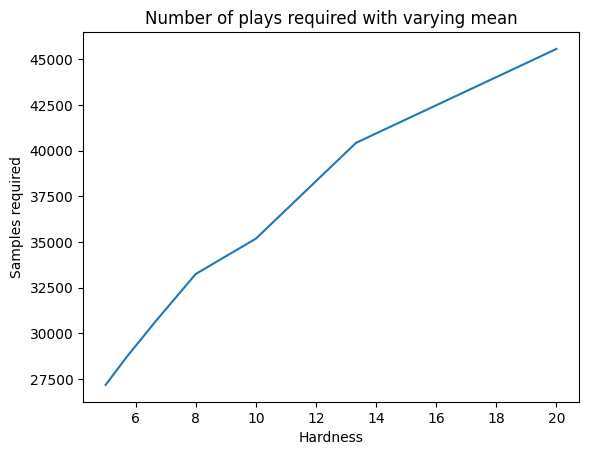

In [21]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 1b

In [ ]:
# self.mu_ij[0] = np.array([x, 1])            #0.75 to 0.85
# self.mu_ij[1] = np.array([0.4, 0.4])        #0.4
# self.mu_ij[2] = np.array([0.2, 0.4])        #0.3
# self.mu_ij[3] = np.array([0.1, 0.5])        #0.3
# self.mu_ij[4] = np.array([0.5, 0.3])        #0.4

# self.ab_array[0] = np.array([[1, (1/x) - 1], [1, 0.01]])        #0.75 to 0.85
# self.ab_array[1] = np.array([[1, 1.5], [1, 1.5]])            #0.4
# self.ab_array[2] = np.array([[1, 4], [1, 1.5]])              #0.3
# self.ab_array[3] = np.array([[1, 9], [1, 1]])                #0.3
# self.ab_array[4] = np.array([[1, 1], [1, 2.33]])             #0.4

# mu_th = 0.45
# x from 0.5 to 0.7
# x, 1.5-x

# self.delta_i[self.i_star]/2 > self.delta_i_attr[self.i_star]
# Basic problem to be addressed is feasibility

In [23]:
N = 5
M = 2
N_iter = 100
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.5, 0.55, 0.6, 0.65, 0.7]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.35)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i)
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
print(samples_ins)


ic| samples_1: 32220, samples_2: 4045
ic| samples_1: 29316, samples_2: 3069
ic| samples_1: 31340, samples_2: 3089
ic| samples_1: 31568, samples_2: 2785
ic| samples_1: 33853, samples_2: 2373


[35570.54, 35101.58, 34337.98, 33942.44, 33639.9]


In [24]:
print(x_val)
print(samples_ins)

[2.899396551724138, 2.703438075851079, 2.5322907921832, 2.38152306872556, 2.247699371128027]
[35570.54, 35101.58, 34337.98, 33942.44, 33639.9]


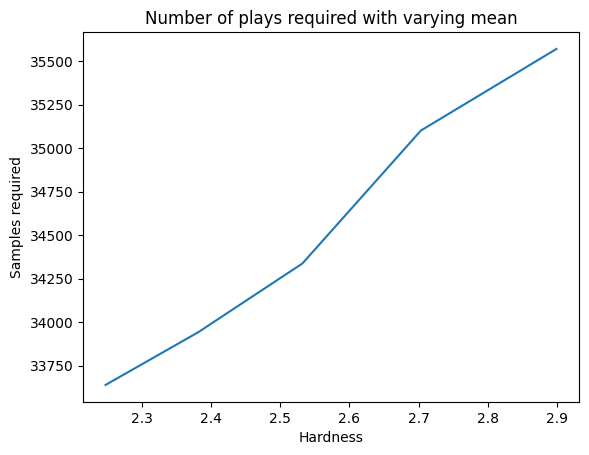

In [25]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 2

In [ ]:
# self.mu_ij[0] = np.array([x, 0.8])        #0.7 to 0.85 - feasible and best
#         self.mu_ij[1] = np.array([0.3, 1])        #0.65 - infeasible
#         self.mu_ij[2] = np.array([0.5, 0.6])        #0.55
#         self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
#         self.mu_ij[4] = np.array([0.1, 0.5])        #0.3 - infeasible

# self.ab_array[0] = np.array([[1, (1/x) - 1], [1, 0.25]])      #0.5
# self.ab_array[1] = np.array([[1, 2.33], [1, 0.01]])           #0.2
# self.ab_array[2] = np.array([[1, 1], [1, 0.67]])              #0.3
# self.ab_array[3] = np.array([[1, 1.5], [1, 1]])               #0.4
# self.ab_array[4] = np.array([[1, 9], [1, 1]])                 #0.3

# mu_th = 0.4

# delta i of arms in set (feasible intersection suboptimal)
# As delta_i increases, sample complexity will decrease

# let 3 arms be feasible
# one of the infeasible arm has highest total mean - this wont be suboptimal - not having this case
# total 3 suboptimal arms
# increase the mean of best arm -> delta_i will increase for all the arms
# vary x from 0.6 to 0.9


In [35]:
N = 5
M = 2
N_iter = 100
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.35)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i)
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
print(samples_ins)


ic| samples_1: 7452, samples_2: 12297
ic| samples_1: 6870, samples_2: 10665
ic| samples_1: 7554, samples_2: 6251
ic| samples_1: 7736, samples_2: 9423
ic| samples_1: 8685, samples_2: 7291
ic| samples_1: 7718, samples_2: 6153
ic| samples_1: 8769, samples_2: 4445


[21020.65, 18857.38, 17152.55, 16285.46, 15087.5, 13980.12, 13300.11]


In [36]:
print(x_val)
print(samples_ins)

[18.24806033313439, 12.531274160045433, 9.5419533300234, 7.704139775401861, 6.459933927473874, 5.561724592685074, 4.882804276972437]
[21020.65, 18857.38, 17152.55, 16285.46, 15087.5, 13980.12, 13300.11]


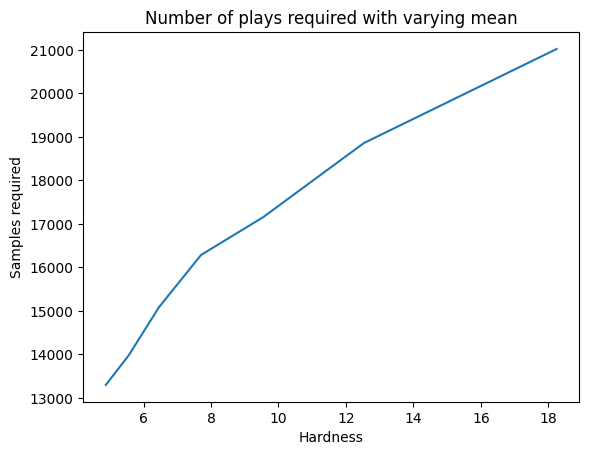

In [37]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 3

In [50]:
# self.mu_ij[0] = np.array([0.55, 0.6])        #0.575
#         self.mu_ij[1] = np.array([0.4, 0.6])        #0.5
#         self.mu_ij[2] = np.array([x, 1])        #0.6 to 0.725- risky and infeasible
#         self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
#         self.mu_ij[4] = np.array([0.1, 0.5])        #0.3 - infeasible

# self.ab_array[0] = np.array([[1, 0.82], [1, 0.67]])           #0.5
# self.ab_array[1] = np.array([[1, 1.5], [1, 0.67]])            #0.3
# self.ab_array[2] = np.array([[1, (1/x) - 1], [1, 0.01]])      #0.2
# self.ab_array[3] = np.array([[1, 1.5], [1, 1]])               #0.4
# self.ab_array[4] = np.array([[1, 9], [1, 1]])                 #0.3

# mu_th = 0.5

# delta_i_attr of arms in set (infeasible intersection risky)
# As delta_i_attr increases, sample complexity will decrease
# risky - mean greater than the best arm, would be infeasible most probably

# as x increases, delta_i_attr decreases, h2 increases
# as x increases, 

# x, 1.2 - x, x varying from 0

In [50]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.2, 0.25, 0.3, 0.35, 0.4]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.45, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.45)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i_attr[2])
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
print(samples_ins)


ic| samples_1: 14581, samples_2: 1
ic| samples_1: 14825, samples_2: 1
ic| samples_1: 16144, samples_2: 1
ic| samples_1: 16054, samples_2: 1
ic| samples_1: 17567, samples_2: 1


[15173.0, 15332.9, 15391.2, 16048.8, 18904.8]


In [51]:
print(x_val)
print(samples_ins)

[4.0, 5.0, 6.666666666666666, 9.999999999999996, 20.000000000000004]
[15173.0, 15332.9, 15391.2, 16048.8, 18904.8]


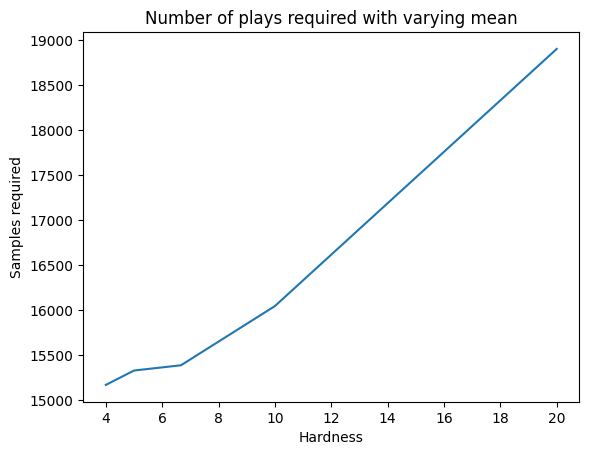

In [52]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 4a

In [ ]:
# self.mu_ij[0] = np.array([0.8, x])        #0.7 to 0.85
#         self.mu_ij[1] = np.array([0.3, 0.5])        #0.4 - infeasible
#         self.mu_ij[2] = np.array([0.4, 0.6])        #0.5 - infeasible
#         self.mu_ij[3] = np.array([0.8, 0.5])        #0.65
#         self.mu_ij[4] = np.array([0.2, 0.4])        #0.3 - infeasible

# self.ab_array[0] = np.array([[1, 0.25], [1, (1/x) - 1]])        #0.5
# self.ab_array[1] = np.array([[1, 2.33], [1, 1]])                #0.2
# self.ab_array[2] = np.array([[1, 1.5], [1, 0.67]])              #0.3
# self.ab_array[3] = np.array([[1, 0.25], [1, 1]])                #0.4
# self.ab_array[4] = np.array([[1, 4], [1, 1.5]])                 #0.3

# mu_th = 0.4

# arms in set (infeasible intersection suboptimal)
# max(delta_i/2, delta_i_attr)
# delta_i/2 > delta_i_attr

# 3 arms infeasible, out of them one will be risky, 2 will be suboptimal
# x varies from 0.6 to 0.9

In [55]:
N = 5
M = 2
N_iter = 50
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.35)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i)
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
print(samples_ins)


ic| samples_1: 10264, samples_2: 23261
ic| samples_1: 11555, samples_2: 22129
ic| samples_1: 11409, samples_2: 22577
ic| samples_1: 12149, samples_2: 14107
ic| samples_1: 10258, samples_2: 16721
ic| samples_1: 10114, samples_2: 10471
ic| samples_1: 12209, samples_2: 9163


[40220.9, 33565.82, 29868.34, 26914.3, 24094.68, 21927.86, 20375.62]


In [56]:
print(x_val)
print(samples_ins)

[20.00000000000003, 13.333333333333321, 10.000000000000002, 8.0, 6.666666666666666, 5.714285714285716, 5.000000000000001]
[40220.9, 33565.82, 29868.34, 26914.3, 24094.68, 21927.86, 20375.62]


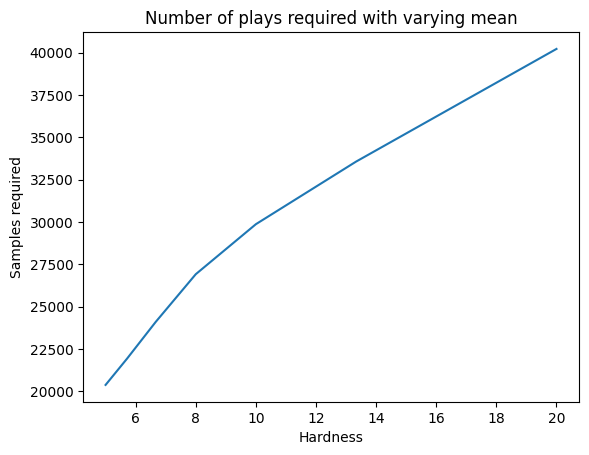

In [57]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 4b

In [ ]:
# self.mu_ij[0] = np.array([0.5, 0.7])        #0.6
#         self.mu_ij[1] = np.array([x, 0.8])        #0.5 - infeasible
#         self.mu_ij[2] = np.array([0.3, 0.5])        #0.4 - infeasible
#         self.mu_ij[3] = np.array([0.5, 0.5])        #0.5
#         self.mu_ij[4] = np.array([0.2, 0.4])        #0.3 - infeasible

# self.ab_array[0] = np.array([[1, 1], [1, 0.43]])               #0.5
# self.ab_array[1] = np.array([[1, (1/x) - 1], [1, 0.25]])       #0.2
# self.ab_array[2] = np.array([[1, 2.33], [1, 1]])               #0.3
# self.ab_array[3] = np.array([[1, 1], [1, 1]])                  #0.4
# self.ab_array[4] = np.array([[1, 4], [1, 1.5]])                #0.3

# mu_th = 0.5
# x from 0.4 to 0.5

# arms in set (infeasible intersection suboptimal)
# max(delta_i/2, delta_i_attr)
# delta_i/2 < delta_i_attr

# 3 arms infeasible, all of them suboptimal
# x, 1-x, x varying from 0.35 to 0.1
# x = 0.1,0.8 mean = 0.45, delta_i/2 = 0.075
# x = 0.3,0.8 mean = 0.55, delta_i/2 = 0.025
# x = 0.35, 0.8, mean = 0.575, delta_i/2 = 0.0125



In [59]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.35)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i)
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
    # print(count)
print(samples_ins)


ic| samples_1: 8488, samples_2: 18629
ic| samples_1: 9368, samples_2: 15277
ic| samples_1: 8583, samples_2: 17757
ic| samples_1: 9121, samples_2: 11331
ic| samples_1: 7523, samples_2: 9873
ic| samples_1: 9775, samples_2: 6677
ic| samples_1: 8083, samples_2: 6533


[25951.0, 23476.0, 21779.3, 19331.1, 17762.6, 17158.3, 15049.1]


In [60]:
print(x_val)
print(samples_ins)

[9.965156794425095, 7.977684797768477, 6.6511627906976765, 5.702891326021935, 4.991273996509599, 4.437548487199381, 3.99441340782123]
[25951.0, 23476.0, 21779.3, 19331.1, 17762.6, 17158.3, 15049.1]


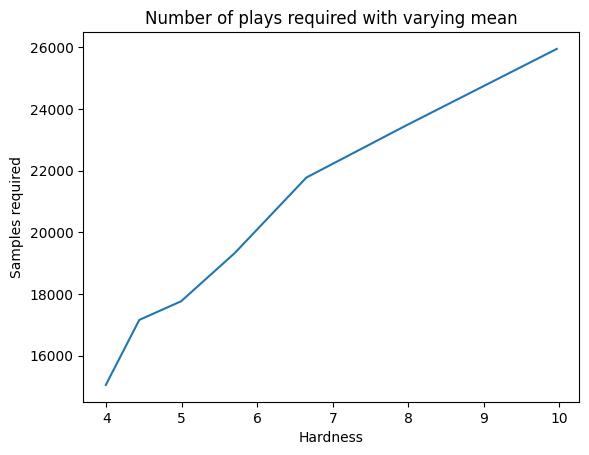

In [61]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 4b modif

In [ ]:
# self.mu_ij[0] = np.array([0.6, 0.7])        #0.6
#         self.mu_ij[1] = np.array([x, 0.9])        #0.5 - infeasible
#         self.mu_ij[2] = np.array([0.3, 0.55])        #0.4 - infeasible
#         self.mu_ij[3] = np.array([0.55, 0.55])        #0.5
#         self.mu_ij[4] = np.array([0.2, 0.4])        #0.3 - infeasible

# self.ab_array[0] = np.array([[1, 0.67], [1, 0.43]])               #0.5
# self.ab_array[1] = np.array([[1, (1/x) - 1], [1, 0.11]])       #0.2
# self.ab_array[2] = np.array([[1, 2.33], [1, 0.82]])               #0.3
# self.ab_array[3] = np.array([[1, 0.82], [1, 0.82]])                  #0.4
# self.ab_array[4] = np.array([[1, 4], [1, 1.5]])                #0.3

# mu_th = 0.5

# arms in set (infeasible intersection suboptimal)
# max(delta_i/2, delta_i_attr)
# delta_i/2 < delta_i_attr

# 3 arms infeasible, all of them suboptimal
# x, 1-x, x varying from 0.35 to 0.1
# x = 0.1,0.8 mean = 0.45, delta_i/2 = 0.075
# x = 0.3,0.8 mean = 0.55, delta_i/2 = 0.025
# x = 0.35, 0.8, mean = 0.575, delta_i/2 = 0.0125



In [63]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.4, 0.42, 0.44, 0.46, 0.48]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        feasible_set, samples_1, delta_i, delta_i_attr = game(M, N, mu_th=0.5, delta=0.1)
        # print(feasible_set)
        best_arm_guess, samples_2 = best_feasible_arm(M, N, feasible_set, delta = 0.1, mu_th = 0.5)
        samples = samples_1 + samples_2
        samples_all.append(samples)
        count[best_arm_guess] += 1

    ic(samples_1, samples_2)
    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(1/delta_i_attr[1])
    # time = h_idx * math.log(h_idx/delta_ins)
    # time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    # print("Done")
    # print(count)
print(samples_ins)


ic| samples_1: 16484, samples_2: 17341
ic| samples_1: 13595, samples_2: 14229
ic| samples_1: 13231, samples_2: 15873
ic| samples_1: 17170, samples_2: 18245
ic| samples_1: 30647, samples_2: 14233


[29346.8, 29105.8, 30033.9, 32629.3, 50019.4]


In [64]:
print(x_val)
print(samples_ins)

[10.000000000000002, 12.499999999999998, 16.666666666666654, 25.000000000000014, 49.99999999999996]
[29346.8, 29105.8, 30033.9, 32629.3, 50019.4]


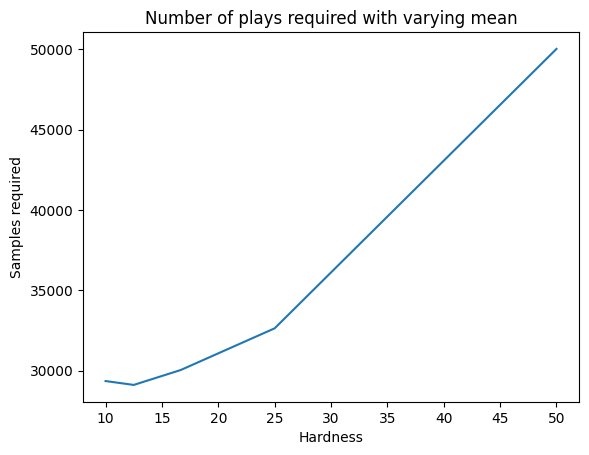

In [65]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()